In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import os
import cv2
import numpy as np

path = "../Data/covid-19/"
data = []
labels = []

for img_class in os.listdir(path):
    class_path = path + img_class + "/"
    for img in os.listdir(class_path):
        img = cv2.imread(class_path + img)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append(img)
        labels.append(img_class)

In [3]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [4]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [11]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = False

In [15]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-3, decay=1e-3 / 25)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit_generator(train_aug.flow(x_train, y_train, batch_size=8), steps_per_epoch=len(x_train) // 8, 
                              validation_data=(x_test, y_test), validation_steps=len(x_test) // 8, epochs=25)

model.save(path + "weights.h5", save_format="h5")

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 12s 2s/step - loss: 0.7631 - accuracy: 0.5000 - val_loss: 0.4741 - val_accuracy: 0.7500
Epoch 2/25
5/5 [==============================] - 2s 395ms/step - loss: 0.7277 - accuracy: 0.6000 - val_loss: 0.4554 - val_accuracy: 0.7500
Epoch 3/25
5/5 [==============================] - 2s 389ms/step - loss: 0.6318 - accuracy: 0.7000 - val_loss: 0.4631 - val_accuracy: 0.8750
Epoch 4/25
5/5 [==============================] - 2s 391ms/step - loss: 0.7078 - accuracy: 0.6250 - val_loss: 0.4884 - val_accuracy: 0.8750
Epoch 5/25
5/5 [==============================] - 2s 402ms/step - loss: 0.7148 - accuracy: 0.5250 - val_loss: 0.4914 - val_accuracy: 0.6250
Epoch 6/25
5/5 [==============================] - 2s 393ms/step - loss: 0.6580 - accuracy: 0.5750 - val_loss: 0.4378 - val_accuracy: 0.8750
Epoch 7/25
5/5 [===

In [16]:
from sklearn.metrics import classification_report

preds = model.predict(x_test, batch_size=8)
preds = np.argmax(preds, axis=1)

print(classification_report(y_test.argmax(axis=1), preds, target_names=label_binarizer.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [17]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test.argmax(axis=1), preds))

[[5 0]
 [0 5]]


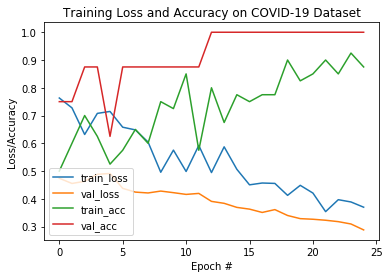

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(0, 25), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 25), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()